In [2]:
from keras.layers.core import Activation, Dense, Dropout, SpatialDropout1D
from keras.layers import Input, LSTM, Dense, Embedding
from keras.models import Sequential, Model
from keras.preprocessing import sequence
from keras.callbacks import TensorBoard
from keras.utils import plot_model
import keras.backend as K

from sklearn.model_selection import train_test_split
from IPython.display import Image
from sklearn.decomposition import PCA
import tensorflow as tf 

import collections
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import time

import pandas as pd
import matplotlib.pyplot as plt
import pickle

In [3]:
data = pd.read_csv('grade_item.csv', sep=",")
data.head()
# 상품별 고객 평점 출력

,CUSTOMER,FASH-WO,FASH-MA,FASH-WAT,FASH-JUR,FASH-UND,FASH-MBAG,FASH-WBAG,FASH-MIS,FASH-WWAL,...,DIGI-CELL,DIGI-NOTE,DIGI-SOUND,DIGI-GAME,DIGI-LIFE,DIGI-PRT,DIGI-PC,DIGI-DISP,DIGI-HARD,PERFORM
0,CUS-1,9,6,7,2,5,3,8,5,7,...,5,2,10,4,6,4,3,10,6,0
1,CUS-2,8,0,6,6,1,9,6,1,2,...,6,1,3,4,3,4,0,3,7,4
2,CUS-3,9,5,8,3,9,6,0,10,4,...,4,6,9,10,1,1,6,1,2,4
3,CUS-4,3,8,3,0,2,8,6,9,7,...,2,1,3,7,6,0,8,1,4,6
4,CUS-5,0,9,1,8,5,1,6,6,2,...,2,1,5,5,0,6,2,7,7,4


In [4]:
data = data.drop("CUSTOMER", 1)
data.head()

,FASH-WO,FASH-MA,FASH-WAT,FASH-JUR,FASH-UND,FASH-MBAG,FASH-WBAG,FASH-MIS,FASH-WWAL,FASH-MWAL,...,DIGI-CELL,DIGI-NOTE,DIGI-SOUND,DIGI-GAME,DIGI-LIFE,DIGI-PRT,DIGI-PC,DIGI-DISP,DIGI-HARD,PERFORM
0,9,6,7,2,5,3,8,5,7,5,...,5,2,10,4,6,4,3,10,6,0
1,8,0,6,6,1,9,6,1,2,9,...,6,1,3,4,3,4,0,3,7,4
2,9,5,8,3,9,6,0,10,4,5,...,4,6,9,10,1,1,6,1,2,4
3,3,8,3,0,2,8,6,9,7,1,...,2,1,3,7,6,0,8,1,4,6
4,0,9,1,8,5,1,6,6,2,1,...,2,1,5,5,0,6,2,7,7,4


In [5]:
# 각 값이 몇 번 나왔는지 출력
data.PERFORM.value_counts()

5     7648
2     7467
8     7460
9     6852
6     6806
1     6798
4     6788
3     6748
7     6698
10    3770
0     2965
Name: PERFORM, dtype: int64

In [6]:
data.shape
# (고객수, 상품수)

(70000, 93)

In [7]:
factor_sum=0

for i in range(data.shape[1]):  # 상품수: 93
    #print(len(data.iloc[:,i].value_counts()))
    factor_sum +=len(data.iloc[:,i].value_counts()) # 점수 범위: 0~10
    
print(factor_sum)
# 93*11 = 1023

1023


In [8]:
# 데이터 순서 섞기
colnames=data.columns
from random import shuffle

REP=1 # number of shuffled sentences
sentences = []
for i in range(data.shape[0]):  # 고객 수
    if i%10000==0:
        print(i)
    for j in range(REP):
        sentence=list(colnames + data.iloc[i,:].map(str))
        np.random.shuffle(sentence)
        sentences.append(sentence)

0
10000
20000
30000
40000
50000
60000


In [9]:
sentences

[['DIGI-CELL5',
  'FASH-MIS5',
  'FURN-LIB3',
  'FOOD-PROC7',
  'CLOTH-MWAL2',
  'FLOWER8',
  'CLOTH-WO5',
  'FASH-WO9',
  'FURN-CHID4',
  'CAT6',
  'BEAT-LOTT2',
  'CLOTH-MA3',
  'FOOD-AGR6',
  'FOOD-WELL8',
  'CLOTH-WBAG6',
  'DIGI-WASH2',
  'BEAT-MAKE3',
  'TRV-AIR10',
  'FOOD-KIMCH5',
  'DIGI-NOTE2',
  'FOOD-MAR5',
  'FASH-MA6',
  'DIGI-PC3',
  'BEAT-SKIN10',
  'DIGI-GAME4',
  'FURN-BED9',
  'OFFICE9',
  'LESR-FISH5',
  'FURN-OUT5',
  'DOG1',
  'FOOD-ANI0',
  'FASH-UND5',
  'LIFE-WASH8',
  'FOOD-SIDI7',
  'LESR-ELEC3',
  'FASH-MBAG3',
  'FASH-MWAL5',
  'LESR-AUTO0',
  'LIFE-BATH8',
  'FASH-JUR2',
  'FASH-WAT7',
  'LESR-GOLF3',
  'LESR-CAP4',
  'LESR-OTH4',
  'FOOD-COFF7',
  'FASH-WWAL7',
  'CLOTH-WWAL5',
  'DIGI-HARD6',
  'CLOTH-WATH1',
  'PERFORM0',
  'FURN-CHR8',
  'LESR-HEAT2',
  'FURN-INN7',
  'CLOTH-CHID6',
  'DIGI-TV7',
  'LIFE-MOU2',
  'FURN-KIT2',
  'DIGI-PRT4',
  'LESR-SKI8',
  'LIFE-MASS8',
  'FISH9',
  'BEAT-PERF5',
  'CLOTH-MSHO1',
  'FURN-DESK3',
  'TRV-TIKE0',
  'DIGI

In [10]:
# 상품 평점별 벡터 생성
from gensim.models import Word2Vec
# 방법: Skip-Gram, 벡터: 50차원, 앞뒤로 단어 확인: 5개씩, 최소 출현 횟수: 1번
embed_model = Word2Vec(sentences, sg=1, size=50, window=5, min_count=1)
embed_model.save("word2vec_ITEM_GRADE")

In [15]:
print(len(embed_model.wv.vocab))
X = embed_model[embed_model.wv.vocab]
print(X.shape)
# 1023개의 단어, 50차원 벡터

1023
(1023, 50)


D:\Users\Yohan\anaconda3\envs\tensorflow_lab\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [16]:
# 단어사전 생성
index2word = {i: w for i, w in enumerate(embed_model.wv.index2word)} 
word2index = {w: i for i, w in index2word.items() }
print(len(embed_model.wv.index2word))
print(len(index2word))
print(len(word2index))

1023
1023
1023


In [17]:
word2index

{'LESR-ELEC2': 0,
 'BOOK8': 1,
 'FASH-MIS8': 2,
 'FURN-DESK2': 3,
 'FOOD-KIMCH8': 4,
 'LESR-SWIM8': 5,
 'FASH-JUR8': 6,
 'BEAT-MAST2': 7,
 'FOOD-DIET8': 8,
 'FOOD-AGR8': 9,
 'FURN-CHR2': 10,
 'LIFE-BATH5': 11,
 'BEAT-BODY2': 12,
 'FURN-CHID2': 13,
 'LESR-CAP8': 14,
 'FLOWER8': 15,
 'DIGI-AIR5': 16,
 'LESR-FISH8': 17,
 'FOOD-SIDI8': 18,
 'PERFORM5': 19,
 'DIGI-HARD8': 20,
 'LESR-BOX2': 21,
 'LESR-GOLF5': 22,
 'LESR-MTN2': 23,
 'FURN-KIT5': 24,
 'FOOD-MAR8': 25,
 'FOOD-DIET2': 26,
 'FOOD-PROC8': 27,
 'TRV-AIR2': 28,
 'BEAT-PERF8': 29,
 'BEAT-MAKE8': 30,
 'DIGI-AIR8': 31,
 'FASH-MIS5': 32,
 'FURN-REM5': 33,
 'BEAT-LOTT2': 34,
 'DIGI-SOUND2': 35,
 'CLOTH-MWAL5': 36,
 'LESR-HEAT8': 37,
 'BEAT-LOTT8': 38,
 'FURN-INN8': 39,
 'LESR-MTN8': 40,
 'CLOTH-WSHO5': 41,
 'FASH-MBAG8': 42,
 'LESR-BYKE2': 43,
 'FASH-MWAL2': 44,
 'DIGI-PRT8': 45,
 'LIFE-MOU2': 46,
 'LESR-CAP2': 47,
 'BEAT-ESSN2': 48,
 'LIFE-MASS8': 49,
 'DIGI-LIFE5': 50,
 'LIFE-PAP5': 51,
 'TRV-TIKE5': 52,
 'DIGI-PC2': 53,
 'ART8': 54,
 

In [18]:
index2word

{0: 'LESR-ELEC2',
 1: 'BOOK8',
 2: 'FASH-MIS8',
 3: 'FURN-DESK2',
 4: 'FOOD-KIMCH8',
 5: 'LESR-SWIM8',
 6: 'FASH-JUR8',
 7: 'BEAT-MAST2',
 8: 'FOOD-DIET8',
 9: 'FOOD-AGR8',
 10: 'FURN-CHR2',
 11: 'LIFE-BATH5',
 12: 'BEAT-BODY2',
 13: 'FURN-CHID2',
 14: 'LESR-CAP8',
 15: 'FLOWER8',
 16: 'DIGI-AIR5',
 17: 'LESR-FISH8',
 18: 'FOOD-SIDI8',
 19: 'PERFORM5',
 20: 'DIGI-HARD8',
 21: 'LESR-BOX2',
 22: 'LESR-GOLF5',
 23: 'LESR-MTN2',
 24: 'FURN-KIT5',
 25: 'FOOD-MAR8',
 26: 'FOOD-DIET2',
 27: 'FOOD-PROC8',
 28: 'TRV-AIR2',
 29: 'BEAT-PERF8',
 30: 'BEAT-MAKE8',
 31: 'DIGI-AIR8',
 32: 'FASH-MIS5',
 33: 'FURN-REM5',
 34: 'BEAT-LOTT2',
 35: 'DIGI-SOUND2',
 36: 'CLOTH-MWAL5',
 37: 'LESR-HEAT8',
 38: 'BEAT-LOTT8',
 39: 'FURN-INN8',
 40: 'LESR-MTN8',
 41: 'CLOTH-WSHO5',
 42: 'FASH-MBAG8',
 43: 'LESR-BYKE2',
 44: 'FASH-MWAL2',
 45: 'DIGI-PRT8',
 46: 'LIFE-MOU2',
 47: 'LESR-CAP2',
 48: 'BEAT-ESSN2',
 49: 'LIFE-MASS8',
 50: 'DIGI-LIFE5',
 51: 'LIFE-PAP5',
 52: 'TRV-TIKE5',
 53: 'DIGI-PC2',
 54: 'ART8',
 

In [19]:
# 각 고객이 메긴 평점 벡터를 합하여 고객 벡터 생성
data_trans=[]
for i in range(data.shape[0]):  # 고객 수
    sentence = sentences[i]
    tmp=[]
    for j in range(len(sentence)):
        tmp.append(X[word2index[sentence[j]]])
    data_trans.append(np.sum(tmp, axis=0)) # embedding vector를 합하여 한 id를 하나의 50-by-1 벡터로 표현 
    
    if i%5000==0:
        print(i)

print('done')

0
5000
10000
15000
20000
25000
30000
35000
40000
45000
50000
55000
60000
65000
done


In [20]:
# 형 변환
data_trans2 = np.array(data_trans)
print(type(data_trans))
print(type(data_trans2))
print(data_trans2.shape)

<class 'list'>
<class 'numpy.ndarray'>
(70000, 50)


In [150]:
# 2차원으로 사상
pca = PCA(n_components=2)
result = pca.fit_transform(data_trans2)
result.shape

(70000, 2)

In [151]:
# 데이터 1000개만 추출
cho_idx = np.random.choice(len(result), 1000)
result2 = result[cho_idx ,]
result2.shape

(1000, 2)

In [153]:
cho_idx

array([55910,  2487, 57373, 32683, 61171, 13555, 34324, 17230, 23301,
        9581, 20001, 65438, 30609, 65759, 50927, 50870, 19283,  4395,
       18840, 12159, 51190, 42105, 56796, 43240, 33676, 46907, 12085,
       26820, 42324, 67774,  7993, 13594, 44346, 20920, 18762,  6795,
       11317, 58032, 41350, 21551, 41475, 44018, 45808, 55890, 12156,
       35737, 43167, 28723, 48199, 55681, 13411, 24127, 20322, 57596,
       11278,  5409, 61609, 26211, 30197, 11560, 60782,  8180, 38425,
       36239,  6861, 52638, 26719, 61918, 53225, 56336, 20142, 28392,
       60491, 47328, 35963, 34795, 32102, 44746, 63504, 16229, 65082,
       24164, 10862, 69400, 68730, 43126, 65041, 18334, 32770, 58558,
       14837, 35950, 19791, 18966, 60729, 57088, 51510, 11457, 41180,
       50216, 34836, 51254, 60767, 38640, 62128, 28225, 64943, 40382,
       61864,  8898, 30892, 26692,  4488, 38098, 31533, 62141, 67816,
       63921,  1078, 27443, 29537, 37645, 37122, 25786, 65392, 42336,
       61350,  8775,

5
10


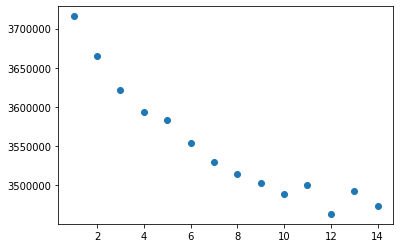

In [180]:
# 군집 분석
from sklearn.cluster import MiniBatchKMeans

# cluster수 별 cost 분석
wss=[]
for i in range(1, 15):
    kmeans=MiniBatchKMeans(n_clusters=i)
    kmeans.fit(data_trans2)
    wss.append(kmeans.inertia_)
    if i%5 == 0:
        print(i)
    
plt.scatter(range(1,15), wss)
plt.show()

In [199]:
K=8  # 군집 수(그래프에서 elbow point 참고) ???
kmeans=MiniBatchKMeans(n_clusters=K)
kmeans.fit(data_trans2)
clusters = kmeans.labels_
unique, counts = np.unique(clusters, return_counts=True)
print(clusters)
print(unique)
print(counts)

[7 7 0 ... 4 1 6]
[0 1 2 3 4 5 6 7]
[8822 8264 8610 8768 8668 8843 9357 8668]


In [200]:
# 참고사항(이 코드가 사용되지는 않음)
# 군집 엔트로피를 구하는 방법
n=data.shape[0]
H_C=0

for k in range(K): # k-th cluster
    n_k=counts[k]
    idx=np.where(clusters==k)
    n_category=0

    for j in range(data.shape[1]): # j-th attribute                
        x=data.iloc[idx[0], j]
        unique_x, counts_x = np.unique(x, return_counts=True)
        
        for m in range(len(counts_x)): # m-th category
            N_jk1=counts_x[m]
            H_C+=-(N_jk1/n_k * np.log(N_jk1/n_k)) * n_k / n
            n_category += 1

# 카테고리 수, 엔트로피 합
print(n_category, H_C)

1023 218.96991364716328


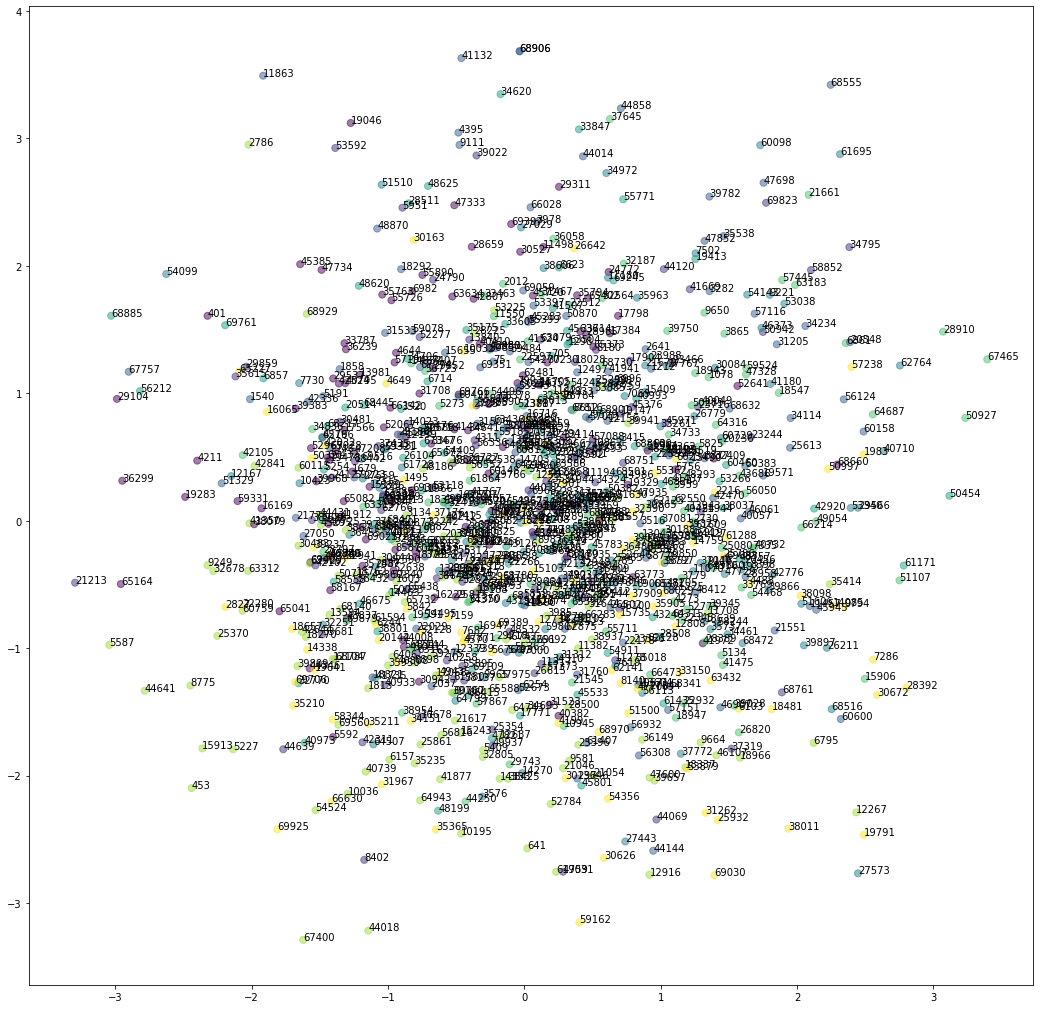

In [202]:
# 좌표 출력
plt.figure(figsize=(18, 18)) 
area = 50
plt.scatter(result2[:, 0], result2[:, 1] , c=clusters[cho_idx]+1, s = area , alpha=0.5)
words = list(data.index[cho_idx])
for i, word in enumerate(words):
    plt.annotate(word, xy=(result2[i, 0], result2[i, 1]))
plt.show()

In [203]:
print(result2.shape)

(1000, 2)


In [204]:
cus_names = list(data.index[cho_idx])
print(len(cus_names))

result3 = np.dot(result2 , result2.T)

df = pd.DataFrame(result3)
df.index = cus_names
df.columns = cus_names
df.to_csv("유사도_UBCF.csv")

1000


In [206]:
df
# 1000명을 추출했으므로 1000명 고객간의 유사도
# 유사도가 높을 수록 고객의 취향이 비슷하다고 예측 가능

,55910,2487,57373,32683,61171,13555,34324,17230,23301,9581,...,21046,54245,68445,13043,29766,18947,5592,23158,17466,6714
55910,1.004140,0.042412,-1.146247,0.178747,-1.300481,0.618704,0.101729,-0.170073,0.339572,-1.884603,...,-1.922960,0.885542,1.263737,-0.412701,0.396287,-1.840592,-1.105778,-0.182647,-0.086956,1.274999
2487,0.042412,1.319155,0.245448,1.097530,-2.909141,-0.108097,-0.675943,0.429824,-0.598676,0.318227,...,0.389025,-0.752629,0.958966,-0.893156,0.118057,-0.655734,2.141341,0.562789,0.346177,0.381752
57373,-1.146247,0.245448,1.374016,0.039097,0.847841,-0.736206,-0.267867,0.291625,-0.524374,2.240057,...,2.299997,-1.187096,-1.240573,0.275760,-0.429769,1.972142,1.750354,0.335757,0.177303,-1.382294
32683,0.178747,1.097530,0.039097,0.933664,-2.593060,-0.000926,-0.544718,0.331303,-0.446762,-0.006317,...,0.046774,-0.496034,0.974238,-0.798035,0.154374,-0.805872,1.613540,0.439519,0.273985,0.498265
61171,-1.300481,-2.909141,0.847841,-2.593060,7.868240,-0.510472,1.342062,-0.726559,0.888386,1.578849,...,1.471624,0.564809,-3.598747,2.431850,-0.732758,3.636069,-3.308525,-0.999509,-0.645369,-2.361706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18947,-1.840592,-0.655734,1.972142,-0.805872,3.636069,-1.075194,0.111984,0.120008,-0.353475,3.279936,...,3.318472,-1.276574,-2.713760,1.140706,-0.770849,3.627403,1.066891,0.084484,0.005895,-2.480943
5592,-1.105778,2.141341,1.750354,1.613540,-3.308525,-0.904275,-1.241855,0.913126,-1.392123,2.736124,...,2.898646,-2.287362,0.112467,-1.000041,-0.268115,1.066891,4.851891,1.148700,0.676834,-0.859436
23158,-0.182647,0.562789,0.335757,0.439519,-0.999509,-0.170669,-0.313092,0.220188,-0.327243,0.515082,...,0.553421,-0.503209,0.162313,-0.304178,-0.028204,0.084484,1.148700,0.280287,0.167324,-0.089912
17466,-0.086956,0.346177,0.177303,0.273985,-0.645369,-0.089226,-0.189460,0.130783,-0.192205,0.268853,...,0.291407,-0.286494,0.131059,-0.196826,-0.007410,0.005895,0.676834,0.167324,0.100439,-0.023333
